In [11]:
# ============================
# 1. Imports & Config
# ============================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import math
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Global config
VOL_SIZE = 32        # 3D volume size: 32 x 32 x 32
LATENT_DIM = 128     # latent size for VAE
TEXT_EMB_DIM = 16    # embedding size for text condition
BATCH_SIZE = 16
N_EPOCHS = 15        # keep small for demo; you can increase later
LR = 1e-3

# Define a small prompt vocabulary
PROMPTS = ["normal", "tumor_left", "tumor_right"]
PROMPT_TO_ID = {p: i for i, p in enumerate(PROMPTS)}
NUM_PROMPTS = len(PROMPTS)


Using device: cpu


In [12]:
# ============================
# 2. Synthetic 3D MRI Dataset
# ============================

def gaussian_3d(shape, center, sigma):
    """
    Create a 3D Gaussian blob.
    shape: (D,H,W)
    center: (cz, cy, cx) in index coordinates
    sigma: std deviation
    """
    dz, dy, dx = shape
    z = np.arange(dz).reshape(-1, 1, 1)
    y = np.arange(dy).reshape(1, -1, 1)
    x = np.arange(dx).reshape(1, 1, -1)

    cz, cy, cx = center
    g = np.exp(-(((z - cz) ** 2) + ((y - cy) ** 2) + ((x - cx) ** 2)) / (2 * sigma ** 2))
    return g

# def make_synthetic_brain(prompt, vol_size=VOL_SIZE):
#     """
#     Make a fake 'brain' volume (1, D, H, W) with different patterns per prompt:
#       - 'normal': central blob
#       - 'tumor_left': central blob + extra blob on left side
#       - 'tumor_right': central blob + extra blob on right side
#     """
#     D = H = W = vol_size

#     # Base "brain" – big central Gaussian
#     base = gaussian_3d(
#         (D, H, W),
#         center=(D // 2, H // 2, W // 2),
#         sigma=vol_size / 4.0
#     )

#     vol = base

#     if prompt == "tumor_left":
#         # Extra blob on left hemisphere
#         tumor = gaussian_3d(
#             (D, H, W),
#             center=(D // 2, H // 2, W // 4),
#             sigma=vol_size / 8.0
#         )
#         vol = vol + 1.5 * tumor

#     elif prompt == "tumor_right":
#         # Extra blob on right hemisphere
#         tumor = gaussian_3d(
#             (D, H, W),
#             center=(D // 2, H // 2, 3 * W // 4),
#             sigma=vol_size / 8.0
#         )
#         vol = vol + 1.5 * tumor

#     # Add small noise so model learns robustly
#     noise = 0.05 * np.random.randn(D, H, W)
#     vol = vol + noise

#     # Normalize to [0,1]
#     vol = vol - vol.min()
#     if vol.max() > 0:
#         vol = vol / vol.max()

#     # Add channel dimension: (1, D, H, W)
#     vol = vol.astype(np.float32)[None, ...]
#     return vol

def make_synthetic_brain(prompt, vol_size=VOL_SIZE):
    """
    Make a fake 'brain' volume (1, D, H, W) with clearer patterns.
    """
    D = H = W = vol_size

    # Base "brain" – smoother, but not too wide
    base = gaussian_3d(
        (D, H, W),
        center=(D // 2, H // 2, W // 2),
        sigma=vol_size / 5.0   # was /4, slightly sharper
    )

    vol = base

    # Sharper, brighter tumor blobs
    if prompt == "tumor_left":
        tumor = gaussian_3d(
            (D, H, W),
            center=(D // 2, H // 2, W // 4),
            sigma=vol_size / 10.0    # smaller blob
        )
        vol = vol + 3.0 * tumor      # brighter than before

    elif prompt == "tumor_right":
        tumor = gaussian_3d(
            (D, H, W),
            center=(D // 2, H // 2, 3 * W // 4),
            sigma=vol_size / 10.0
        )
        vol = vol + 3.0 * tumor

    # Much smaller noise than before
    noise = 0.01 * np.random.randn(D, H, W)  # was 0.05
    vol = vol + noise

    # Normalize to [0,1]
    vol = vol - vol.min()
    if vol.max() > 0:
        vol = vol / vol.max()

    # Optional: boost contrast to emphasize bright regions
    vol = vol ** 1.5   # gamma correction: >1 makes brights brighter

    vol = vol.astype(np.float32)[None, ...]
    return vol


class SyntheticBrainMRIDataset(Dataset):
    def __init__(self, prompts, n_samples_per_prompt=50, vol_size=VOL_SIZE):
        super().__init__()
        self.data = []
        self.labels = []
        self.prompts = prompts
        self.vol_size = vol_size

        for p in prompts:
            for _ in range(n_samples_per_prompt):
                vol = make_synthetic_brain(p, vol_size=self.vol_size)
                self.data.append(vol)
                self.labels.append(PROMPT_TO_ID[p])

        self.data = np.stack(self.data, axis=0)  # (N, 1, D, H, W)
        self.labels = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        vol = torch.from_numpy(self.data[idx])      # (1, D, H, W)
        label = torch.tensor(self.labels[idx])     # scalar
        return vol, label


# Create dataset & dataloader
dataset = SyntheticBrainMRIDataset(PROMPTS, n_samples_per_prompt=80, vol_size=VOL_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Dataset size:", len(dataset))


Dataset size: 240


In [13]:
# ============================
# 3. Conditional 3D VAE Model
# ============================

class Encoder3D(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1)   # 32 -> 16
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1)  # 16 -> 8
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1) # 8 -> 4
        self.bn1 = nn.BatchNorm3d(32)
        self.bn2 = nn.BatchNorm3d(64)
        self.bn3 = nn.BatchNorm3d(128)

        self.flatten_dim = 128 * 4 * 4 * 4
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        # x: (B, 1, D, H, W) with D=H=W=32
        x = F.relu(self.bn1(self.conv1(x)))  # -> (B, 32, 16, 16, 16)
        x = F.relu(self.bn2(self.conv2(x)))  # -> (B, 64, 8, 8, 8)
        x = F.relu(self.bn3(self.conv3(x)))  # -> (B,128, 4, 4, 4)
        x = x.view(x.size(0), -1)            # -> (B, flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder3D(nn.Module):
    def __init__(self, latent_dim, text_emb_dim, num_prompts):
        super().__init__()
        self.text_emb = nn.Embedding(num_prompts, text_emb_dim)

        self.fc = nn.Linear(latent_dim + text_emb_dim, 128 * 4 * 4 * 4)

        self.deconv1 = nn.ConvTranspose3d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # 4 -> 8
        self.deconv2 = nn.ConvTranspose3d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # 8 -> 16
        self.deconv3 = nn.ConvTranspose3d(
            32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # 16 -> 32

        self.conv_out = nn.Conv3d(16, 1, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(32)
        self.bn3 = nn.BatchNorm3d(16)

    def forward(self, z, text_ids):
        """
        z: (B, latent_dim)
        text_ids: (B,) long
        """
        t = self.text_emb(text_ids)  # (B, text_emb_dim)
        x = torch.cat([z, t], dim=1)  # (B, latent_dim + text_emb_dim)

        x = self.fc(x)               # (B, 128*4*4*4)
        x = x.view(-1, 128, 4, 4, 4) # (B, 128, 4, 4, 4)

        x = F.relu(self.bn1(self.deconv1(x)))  # -> (B, 64, 8, 8, 8)
        x = F.relu(self.bn2(self.deconv2(x)))  # -> (B, 32, 16,16,16)
        x = F.relu(self.bn3(self.deconv3(x)))  # -> (B, 16, 32,32,32)

        x = self.conv_out(x)                   # -> (B,1,32,32,32)
        x = torch.sigmoid(x)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder3D(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1)   # 32 -> 16
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1)  # 16 -> 8
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1) # 8 -> 4
        self.bn1 = nn.BatchNorm3d(32)
        self.bn2 = nn.BatchNorm3d(64)
        self.bn3 = nn.BatchNorm3d(128)

        self.flatten_dim = 128 * 4 * 4 * 4
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder3D(nn.Module):
    def __init__(self, latent_dim, text_emb_dim, num_prompts):
        super().__init__()
        self.text_emb = nn.Embedding(num_prompts, text_emb_dim)

        self.fc = nn.Linear(latent_dim + text_emb_dim, 128 * 4 * 4 * 4)

        self.deconv1 = nn.ConvTranspose3d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose3d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose3d(
            32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
        )

        self.conv_out = nn.Conv3d(16, 1, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(32)
        self.bn3 = nn.BatchNorm3d(16)

    def forward(self, z, text_ids):
        t = self.text_emb(text_ids)                # (B, text_emb_dim)
        x = torch.cat([z, t], dim=1)              # (B, latent + text_emb_dim)
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4, 4)

        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = self.conv_out(x)
        x = torch.sigmoid(x)
        return x


class ConditionalVAE3D(nn.Module):
    def __init__(self, latent_dim, text_emb_dim, num_prompts):
        super().__init__()
        self.encoder = Encoder3D(latent_dim)
        self.decoder = Decoder3D(latent_dim, text_emb_dim, num_prompts)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, text_ids):
        return self.decoder(z, text_ids)

    def forward(self, x, text_ids):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, text_ids)
        return x_recon, mu, logvar


In [15]:
# ============================
# 4. Training Loop
# ============================

model = ConditionalVAE3D(
    latent_dim=LATENT_DIM,
    text_emb_dim=TEXT_EMB_DIM,
    num_prompts=NUM_PROMPTS
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# def vae_loss(recon_x, x, mu, logvar, beta=1e-3):
#     # Reconstruction loss
#     recon_loss = F.mse_loss(recon_x, x, reduction='mean')
#     # KL divergence
#     kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + beta * kl, recon_loss.item(), kl.item()

def vae_loss(recon_x, x, mu, logvar, beta=1e-3):
    # Reconstruction loss – use L1 instead of MSE
    recon_loss = F.l1_loss(recon_x, x, reduction='mean')
    # KL divergence
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl, recon_loss.item(), kl.item()

model.train()
for epoch in range(1, N_EPOCHS + 1):
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n_batches = 0

    for vols, labels in dataloader:
        vols = vols.to(device)          # (B,1,D,H,W)
        labels = labels.to(device)      # (B,)

        optimizer.zero_grad()
        recon, mu, logvar = model(vols, labels)
        loss, recon_l, kl_l = vae_loss(recon, vols, mu, logvar, beta=1e-3)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_l
        total_kl += kl_l
        n_batches += 1

    print(
        f"Epoch [{epoch}/{N_EPOCHS}] "
        f"loss={total_loss/n_batches:.4f} "
        f"recon={total_recon/n_batches:.4f} "
        f"kl={total_kl/n_batches:.4f}"
    )


Epoch [1/15] loss=0.2446 recon=0.2431 kl=1.4722
Epoch [2/15] loss=0.0305 recon=0.0290 kl=1.5822
Epoch [3/15] loss=0.0129 recon=0.0115 kl=1.3323
Epoch [4/15] loss=0.0104 recon=0.0092 kl=1.2236
Epoch [5/15] loss=0.0101 recon=0.0089 kl=1.1931
Epoch [6/15] loss=0.0162 recon=0.0126 kl=3.5752
Epoch [7/15] loss=0.0103 recon=0.0090 kl=1.3123
Epoch [8/15] loss=0.0087 recon=0.0076 kl=1.1362
Epoch [9/15] loss=0.0079 recon=0.0070 kl=0.9636
Epoch [10/15] loss=0.0074 recon=0.0066 kl=0.7979
Epoch [11/15] loss=0.0074 recon=0.0066 kl=0.7493
Epoch [12/15] loss=0.0075 recon=0.0068 kl=0.7254
Epoch [13/15] loss=0.0087 recon=0.0079 kl=0.7889
Epoch [14/15] loss=0.0094 recon=0.0086 kl=0.8373
Epoch [15/15] loss=0.0083 recon=0.0074 kl=0.9428


In [16]:
model.eval()


ConditionalVAE3D(
  (encoder): Encoder3D(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=8192, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=8192, out_features=128, bias=True)
  )
  (decoder): Decoder3D(
    (text_emb): Embedding(3, 16)
    (fc): Linear(in_features=144, out_features=8192, bias=True)
    (deconv1): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (deconv2): ConvTranspose3d(

In [17]:
import math
import matplotlib.pyplot as plt

def generate_from_prompt(prompt, n_samples=1):
    """
    Generate synthetic 3D 'MRI' volumes conditioned on a text prompt.
    Returns tensor (n_samples, 1, D, H, W).
    """
    if prompt not in PROMPT_TO_ID:
        raise ValueError(f"Unknown prompt '{prompt}'. Available: {list(PROMPT_TO_ID.keys())}")

    model.eval()
    with torch.no_grad():
        text_id = PROMPT_TO_ID[prompt]
        text_ids = torch.full((n_samples,), text_id, dtype=torch.long, device=device)
        z = torch.randn(n_samples, LATENT_DIM, device=device)
        samples = model.decode(z, text_ids)  # (N,1,D,H,W)
    return samples.cpu()


In [18]:
samples_normal = generate_from_prompt("normal", n_samples=3)
samples_left   = generate_from_prompt("tumor_left", n_samples=3)
samples_right  = generate_from_prompt("tumor_right", n_samples=3)

print(samples_normal.shape)   # should be (3, 1, 32, 32, 32)


torch.Size([3, 1, 32, 32, 32])


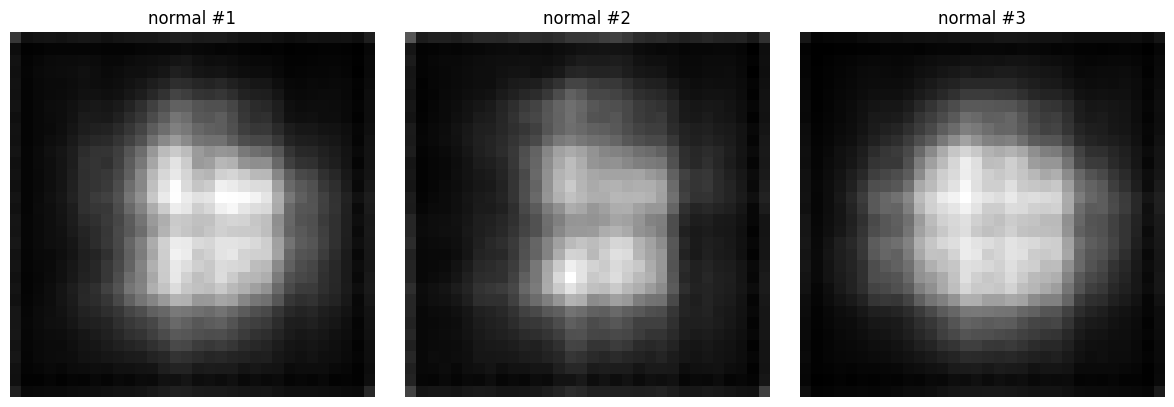

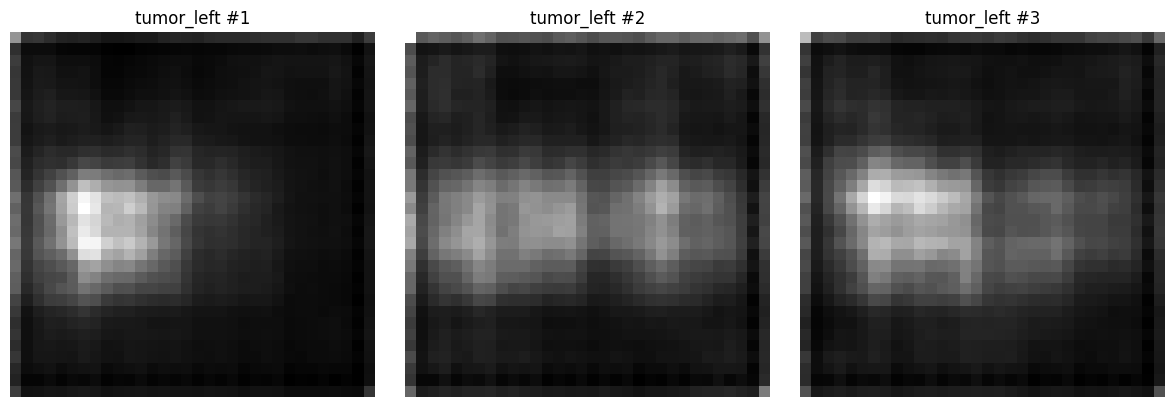

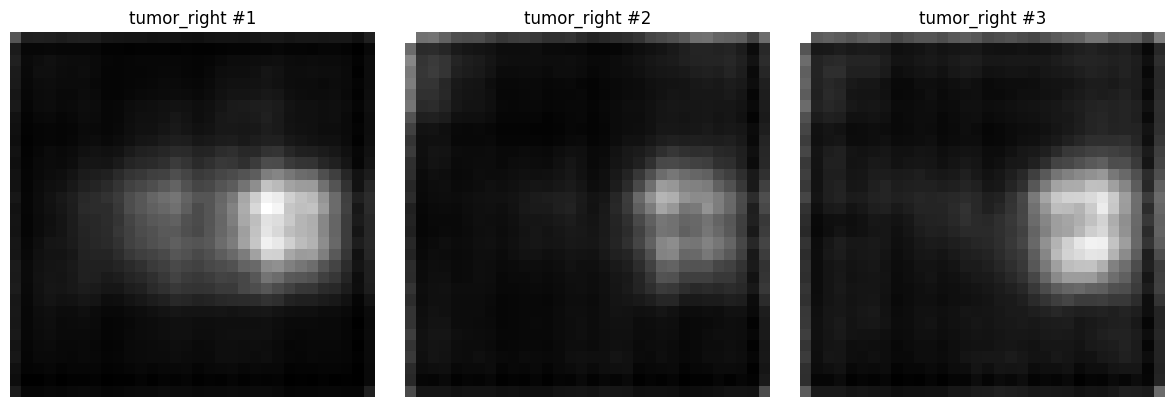

In [19]:
def show_slices_for_prompt(samples, prompt, n_cols=3):
    """
    Show middle slice for several generated volumes.
    samples: (N,1,D,H,W)
    """
    n_samples = samples.shape[0]
    n_cols = min(n_cols, n_samples)
    n_rows = math.ceil(n_samples / n_cols)

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))
    for i in range(n_samples):
        vol = samples[i, 0].numpy()          # (D,H,W)
        mid_slice = vol[vol.shape[0] // 2]   # central slice

        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(mid_slice, cmap="gray", interpolation="nearest")
        ax.axis("off")
        ax.set_title(f"{prompt} #{i+1}")
    plt.tight_layout()
    plt.show()

# Visualize for each prompt
show_slices_for_prompt(samples_normal, "normal")
show_slices_for_prompt(samples_left,   "tumor_left")
show_slices_for_prompt(samples_right,  "tumor_right")
